In [294]:
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

In [99]:
plt.set_cmap('gray')

<Figure size 640x480 with 0 Axes>

In [290]:
datasets.FashionMNIST

torchvision.datasets.fakedata.FakeData

In [342]:
from torch.utils.data.dataloader import default_collate

transform = transforms.ToTensor()

from time import time 
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")

batch_size = 256

mnist_data_train = datasets.FashionMNIST(root = './data', train = True, download = "True", transform = transform)
data_loader_train = torch.utils.data.DataLoader(dataset = mnist_data_train, batch_size = batch_size, shuffle = True, collate_fn=lambda x: tuple(x_.to(mps_device) for x_ in default_collate(x)))

mnist_data_test = datasets.FashionMNIST(root = './data', train = False, download = "True", transform = transform)
data_loader_test = torch.utils.data.DataLoader(dataset = mnist_data_test, batch_size = batch_size, shuffle = True, collate_fn=lambda x: tuple(x_.to(mps_device) for x_ in default_collate(x)))

In [343]:
mnist_data_train, mnist_data_test

(Dataset FashionMNIST
     Number of datapoints: 60000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset FashionMNIST
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: ToTensor())

tensor(5, device='mps:0')


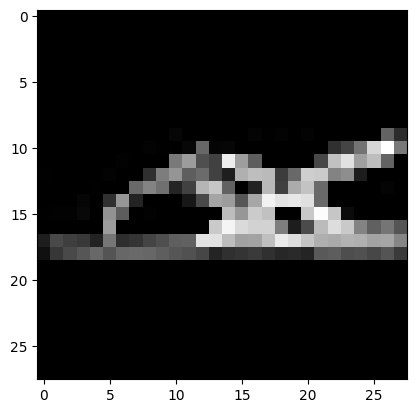

In [350]:
val = next(iter(data_loader_train))
plt.imshow(val[0][0].permute(1,2,0).cpu())
print(val[1][0])

In [351]:
class Autoencoder(nn.Module):
  def __init__(self):
    super(Autoencoder, self).__init__()
    self.encoder_layers = [
      nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1),  # 16, 14x14
      nn.ReLU(),
      nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),  # 32, 7x7
      nn.ReLU(),
      nn.Conv2d(in_channels=32, out_channels=64, kernel_size=7, stride=2, padding=1),  # 64, 4x4
    ]
    self.decoder_layers = [
      nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=7, stride=2, padding=1),  # 32, 7x7
      nn.ReLU(),
      nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding = 1),  # 16, 14x14
      nn.ReLU(),
      nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding = 1),  # 1, 28x28
    ]

    self.encoder = nn.Sequential(*self.encoder_layers)
    self.decoder = nn.Sequential(*self.decoder_layers)

  def forward(self, x):
      return self.decoder(self.encoder(x))


model = Autoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)


In [352]:
start = time()

model = Autoencoder()
model.zero_grad()
model.to(mps_device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, weight_decay= 1e-5)


epochs = 50
outputs = []

for epoch in range(epochs):
    for (img, _) in data_loader_train:
        img = img.to(mps_device)
        # img = img.reshape(-1, 28*28)
        pred = model(img)
        loss = criterion(pred, img)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch: {epoch} | loss: {loss.item():.4f}")
    outputs.append((epoch, img, loss))
    
print(f"\nTime taken: {time() - start:.2f}s")

Epoch: 0 | loss: 0.0182
Epoch: 1 | loss: 0.0127
Epoch: 2 | loss: 0.0101
Epoch: 3 | loss: 0.0082
Epoch: 4 | loss: 0.0063
Epoch: 5 | loss: 0.0066
Epoch: 6 | loss: 0.0071
Epoch: 7 | loss: 0.0055
Epoch: 8 | loss: 0.0049
Epoch: 9 | loss: 0.0049
Epoch: 10 | loss: 0.0045
Epoch: 11 | loss: 0.0048
Epoch: 12 | loss: 0.0040
Epoch: 13 | loss: 0.0041
Epoch: 14 | loss: 0.0043
Epoch: 15 | loss: 0.0043
Epoch: 16 | loss: 0.0037
Epoch: 17 | loss: 0.0039
Epoch: 18 | loss: 0.0037
Epoch: 19 | loss: 0.0035
Epoch: 20 | loss: 0.0037
Epoch: 21 | loss: 0.0056
Epoch: 22 | loss: 0.0043
Epoch: 23 | loss: 0.0034
Epoch: 24 | loss: 0.0033
Epoch: 25 | loss: 0.0037
Epoch: 26 | loss: 0.0034
Epoch: 27 | loss: 0.0030
Epoch: 28 | loss: 0.0029
Epoch: 29 | loss: 0.0032
Epoch: 30 | loss: 0.0030
Epoch: 31 | loss: 0.0030
Epoch: 32 | loss: 0.0028
Epoch: 33 | loss: 0.0032
Epoch: 34 | loss: 0.0033
Epoch: 35 | loss: 0.0031
Epoch: 36 | loss: 0.0026
Epoch: 37 | loss: 0.0030
Epoch: 38 | loss: 0.0031
Epoch: 39 | loss: 0.0026
Epoch: 40 

In [257]:
img.shape

torch.Size([256, 1, 28, 28])

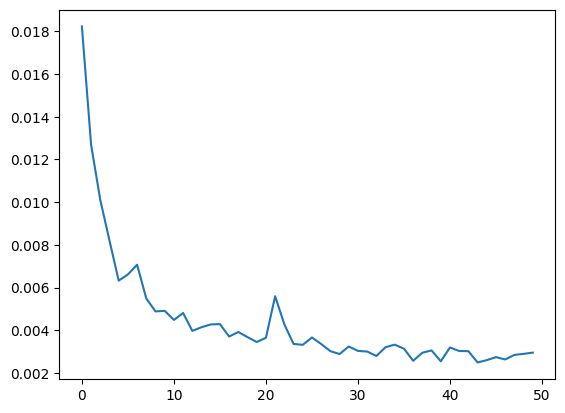

In [353]:
plt.plot([outputs[i][2].item() for i in range(epochs)])

In [354]:
actu_pred = []
epochs = 1

with torch.no_grad():
    for epoch in range(epochs):
        for (img, _) in data_loader_train:
            # img = img.reshape(-1, 28*28)
            pred = model(img)
            
            actu_pred.append([img,pred])

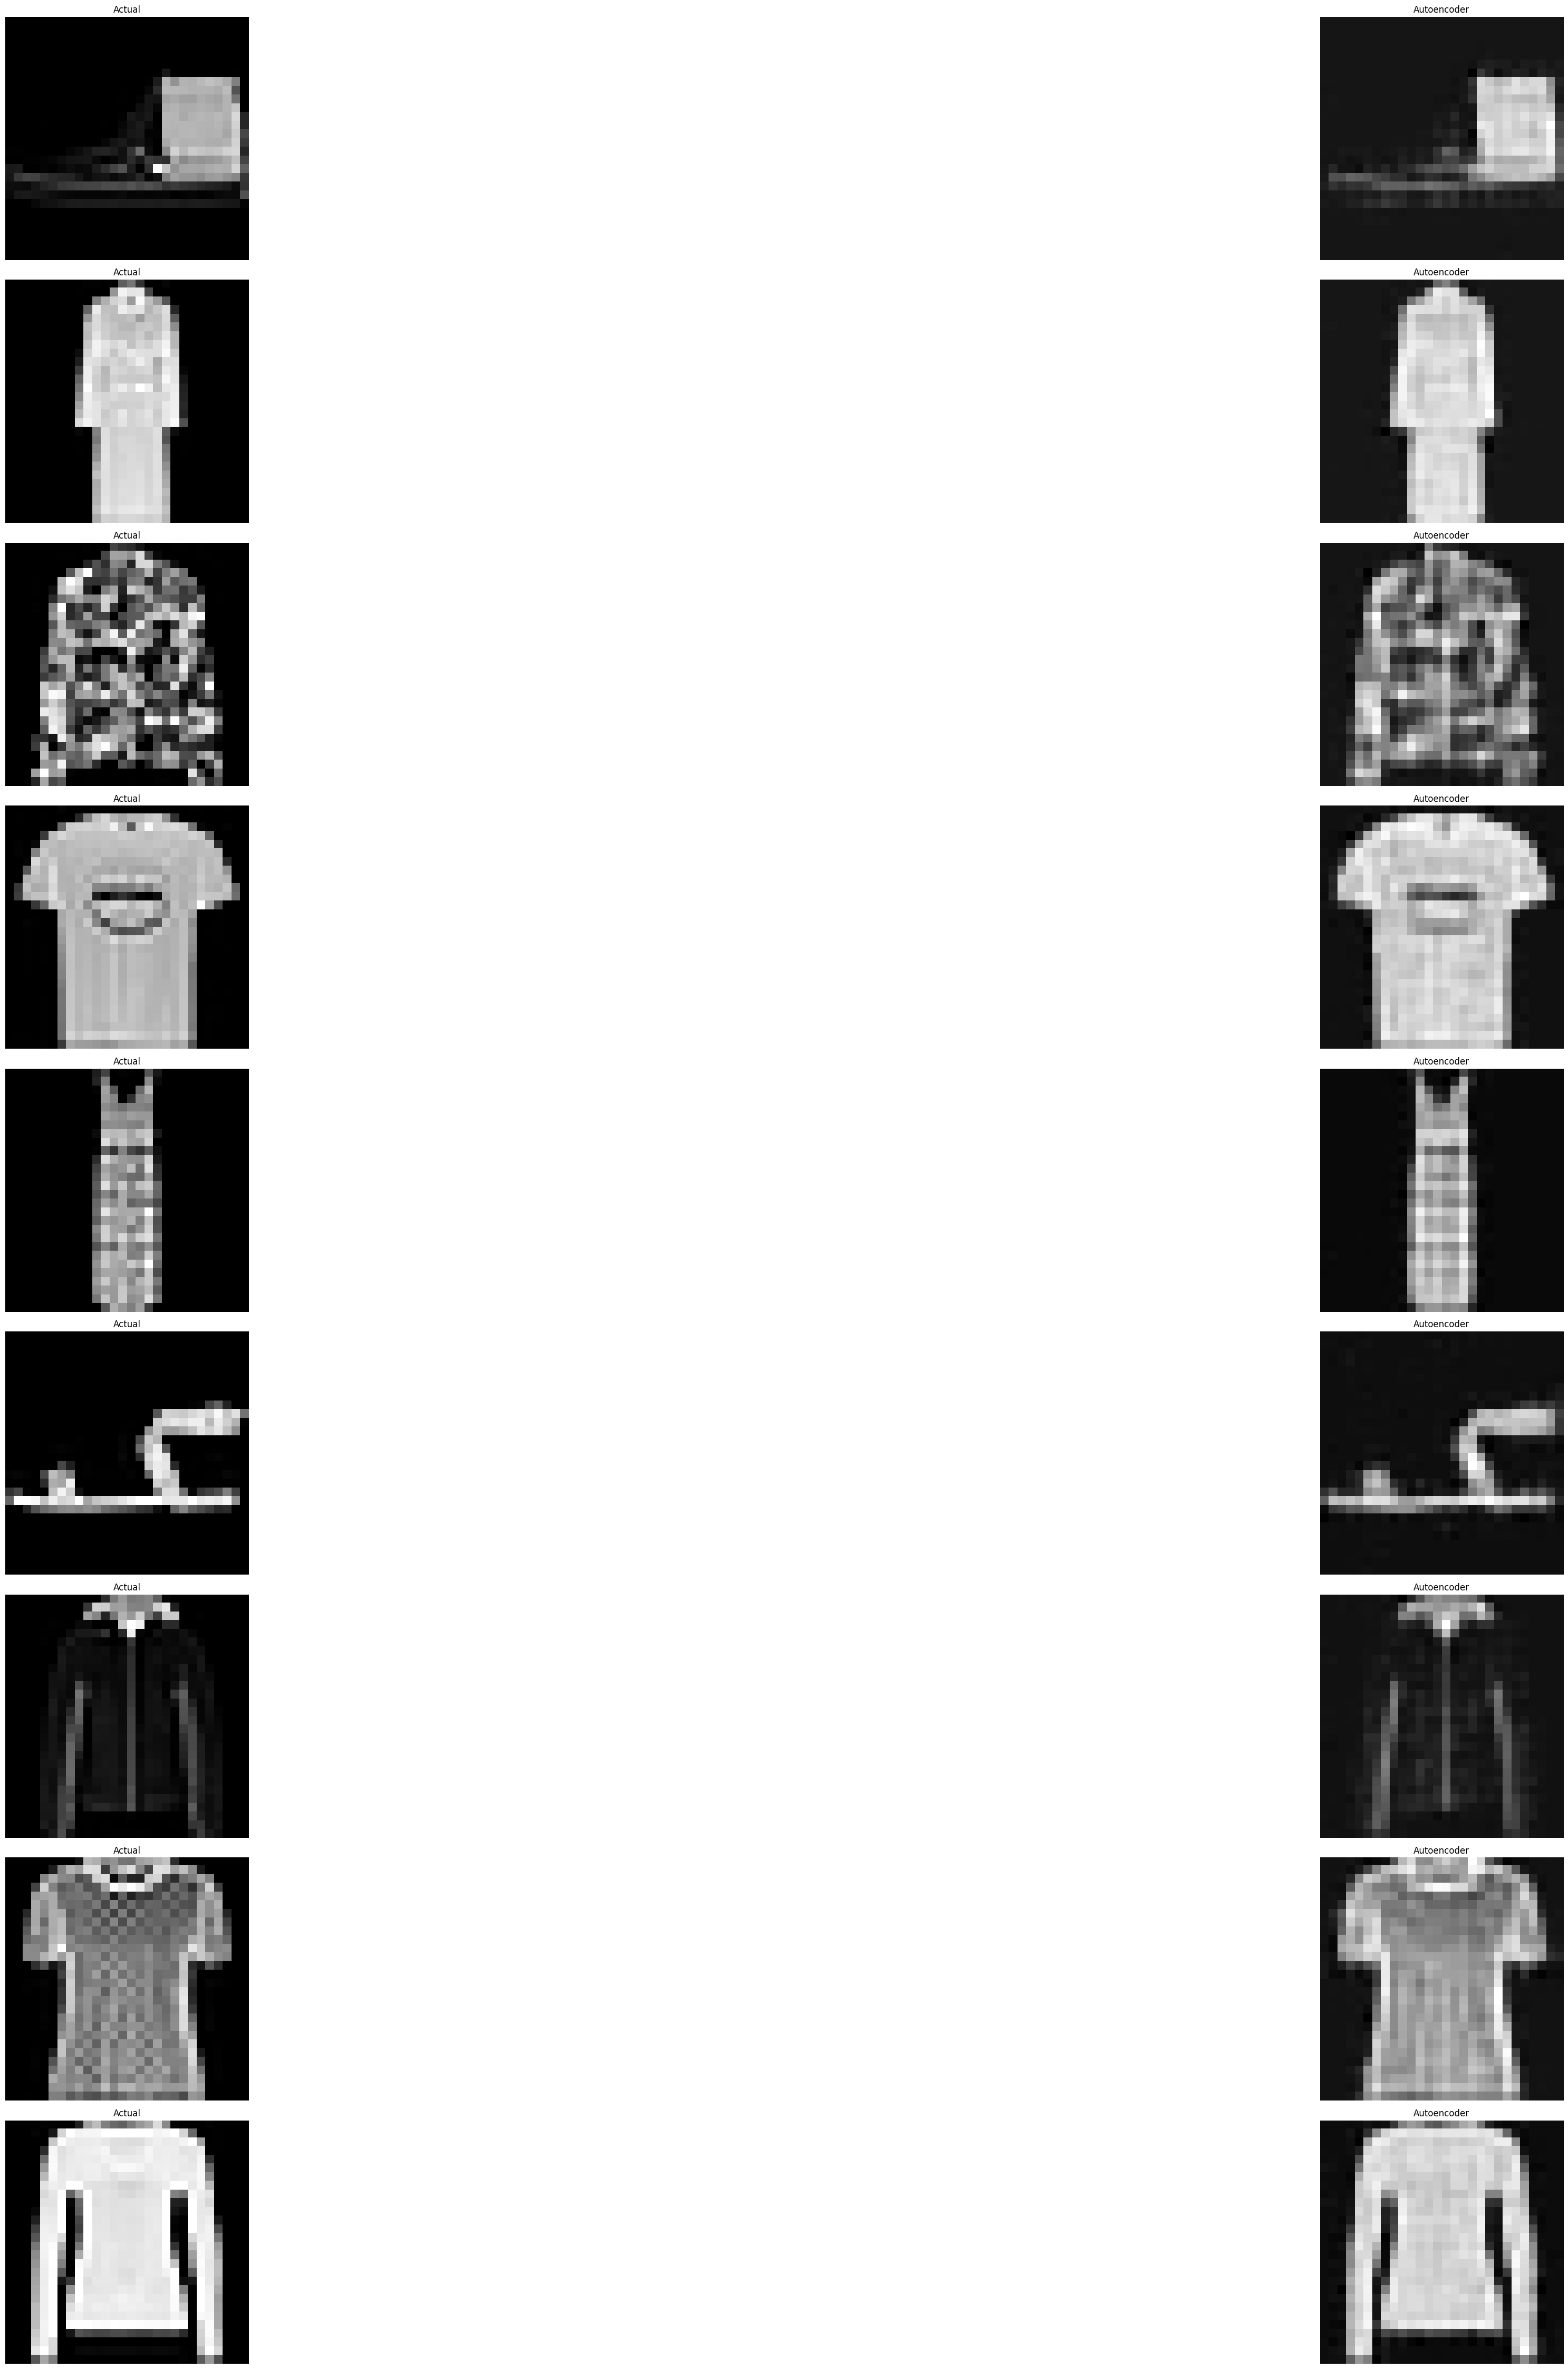

In [358]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(50, 50))
rows = 10
columns = 2

for i in range(rows-1):  # Adjusted loop range

    fig.add_subplot(rows, columns, 2*i+1)  # Adjusted subplot index
    plt.imshow(actu_pred[i][0].reshape(-1, 28, 28)[0].cpu().numpy())
    plt.axis('off') 
    plt.title("Actual") 

    fig.add_subplot(rows, columns, 2*i+2)  # Adjusted subplot index
    plt.imshow(actu_pred[i][1].reshape(-1, 28, 28)[0].cpu().numpy())
    plt.axis('off') 
    plt.title("Autoencoder") 

plt.tight_layout()
plt.show()  # Display the plot


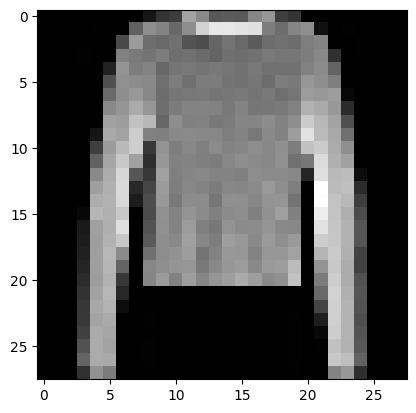

In [362]:
plt.imshow(actu_pred[10][0].reshape(-1, 28,28)[0].cpu().numpy())
plt.show()

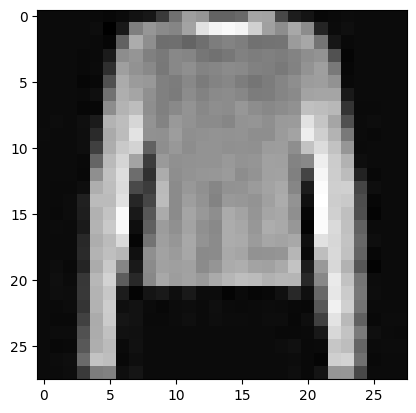

In [363]:
plt.imshow(actu_pred[10][1].reshape(-1, 28,28)[0].cpu().numpy())
plt.show()